https://medium.com/@jonathan_hui/rl-trust-region-policy-optimization-trpo-explained-a6ee04eeeee9
https://stackoverflow.com/a/50663200

In [1]:
# !pip3 install ufal.pybox2d
# !pip3 install gymnasium
# !pip3 install pygame
# !pip3 install opencv-python

In [2]:
# !pip3 install torch
# !pip3 install matplotlib
# !pip3 install numpy

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

In [5]:
train_env = gym.make('LunarLander-v3')
test_env = gym.make('LunarLander-v3')

In [6]:
SEED = 1234

# train_env.seed(SEED);
# test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [7]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.1):
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [8]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [9]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [10]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [11]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (critic): MLP(
    (net): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): PReLU(num_parameters=1)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): Dropout(p=0.1, inplace=False)
      (5): PReLU(num_parameters=1)
      (6): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [12]:
LEARNING_RATE = 0.0005

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [13]:
def train(env, policy, optimizer, discount_factor, ppo_steps, ppo_clip):
        
    policy.train()
        
    states = []
    actions = []
    log_prob_actions = []
    values = []
    rewards = []
    done = False
    truncated = False
    episode_reward = 0

    state, _ = env.reset()

    while not done and not truncated:

        state = torch.FloatTensor(state).unsqueeze(0)

        #append state here, not after we get the next state from env.step()
        states.append(state)
        
        action_pred, value_pred = policy(state)
                
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)
        
        action = dist.sample()
        
        log_prob_action = dist.log_prob(action)
        
        state, reward, done, truncated, _ = env.step(action.item())
        actions.append(action)
        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)
        
        episode_reward += reward
    
    states = torch.cat(states)
    actions = torch.cat(actions)    
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)
    
    returns = calculate_returns(rewards, discount_factor)
    advantages = calculate_advantages(returns, values)
    
    policy_loss, value_loss = update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip)

    return policy_loss, value_loss, episode_reward

In [14]:
def calculate_returns(rewards, discount_factor, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [15]:
def calculate_advantages(returns, values, normalize = True):
    
    advantages = returns - values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [16]:
def update_policy(policy, states, actions, log_prob_actions, advantages, returns, optimizer, ppo_steps, ppo_clip):
    
    total_policy_loss = 0 
    total_value_loss = 0
    
    states = states.detach()
    actions = actions.detach()
    log_prob_actions = log_prob_actions.detach()
    advantages = advantages.detach()
    returns = returns.detach()
    
    for _ in range(ppo_steps):
                
        #get new log prob of actions for all input states
        action_pred, value_pred = policy(states)
        value_pred = value_pred.squeeze(-1)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        
        #new log prob using old actions
        new_log_prob_actions = dist.log_prob(actions)
        
        policy_ratio = (new_log_prob_actions - log_prob_actions).exp()
                
        policy_loss_1 = policy_ratio * advantages
        policy_loss_2 = torch.clamp(policy_ratio, min = 1.0 - ppo_clip, max = 1.0 + ppo_clip) * advantages
        
        policy_loss = - torch.min(policy_loss_1, policy_loss_2).mean()
        
        value_loss = F.smooth_l1_loss(returns, value_pred).mean()
    
        optimizer.zero_grad()

        policy_loss.backward()
        value_loss.backward()

        optimizer.step()
    
        total_policy_loss += policy_loss.item()
        total_value_loss += value_loss.item()
    
    return total_policy_loss / ppo_steps, total_value_loss / ppo_steps

In [17]:
def evaluate(env, policy):
    
    policy.eval()
    
    rewards = []
    done = False
    truncated = False
    episode_reward = 0

    state, _ = env.reset()

    while not done and not truncated:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():
        
            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)
                
        action = torch.argmax(action_prob, dim = -1)
                
        state, reward, done, truncated, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [16]:
MAX_EPISODES = 2000
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 210
PRINT_EVERY = 10
PPO_STEPS = 5
PPO_CLIP = 0.2

train_rewards = []
test_rewards = []

for episode in range(1, MAX_EPISODES+1):
    policy_loss, value_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    test_reward = evaluate(test_env, policy)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    if episode % PRINT_EVERY == 0:
        
        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:7.1f} | Mean Test Rewards: {mean_test_rewards:7.1f} |')
    
    if mean_test_rewards >= REWARD_THRESHOLD:
        # Save the entire object
        torch.save(policy, "policy_complete.pth")
        print(f'Reached reward threshold in {episode} episodes')
        break   

| Episode:  10 | Mean Train Rewards:  -193.3 | Mean Test Rewards:  -318.7 |
| Episode:  20 | Mean Train Rewards:  -168.2 | Mean Test Rewards:  -309.0 |
| Episode:  30 | Mean Train Rewards:  -141.0 | Mean Test Rewards:  -446.9 |
| Episode:  40 | Mean Train Rewards:  -129.4 | Mean Test Rewards:  -875.6 |
| Episode:  50 | Mean Train Rewards:  -108.5 | Mean Test Rewards:  -934.6 |
| Episode:  60 | Mean Train Rewards:  -121.7 | Mean Test Rewards:  -746.7 |
| Episode:  70 | Mean Train Rewards:  -141.0 | Mean Test Rewards:  -735.2 |
| Episode:  80 | Mean Train Rewards:  -178.9 | Mean Test Rewards:  -605.6 |
| Episode:  90 | Mean Train Rewards:  -239.3 | Mean Test Rewards:  -588.3 |
| Episode: 100 | Mean Train Rewards:  -248.1 | Mean Test Rewards:  -554.6 |
| Episode: 110 | Mean Train Rewards:  -104.6 | Mean Test Rewards:  -485.9 |
| Episode: 120 | Mean Train Rewards:   -63.2 | Mean Test Rewards:  -420.7 |
| Episode: 130 | Mean Train Rewards:   -59.0 | Mean Test Rewards:  -493.1 |
| Episode: 1

KeyboardInterrupt: 

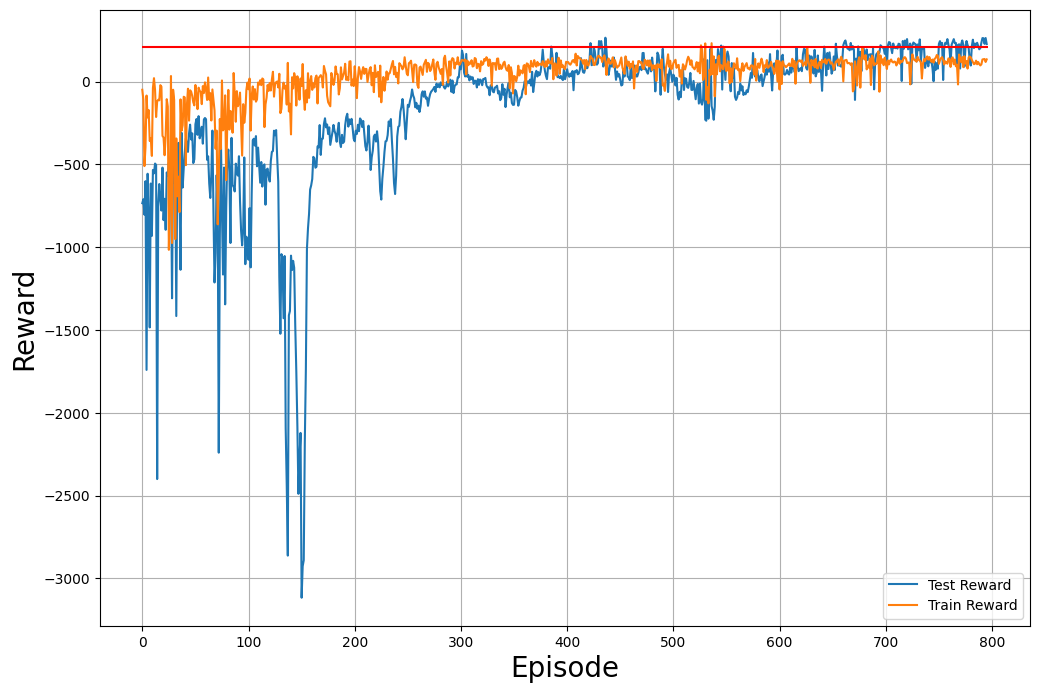

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
plt.grid()

In [21]:
!pip3 install moviepy


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 39.1 kB/s eta 0:00:00a 0:00:06
  Created wheel for imageio_ffmpeg: filename=imageio_ffmpeg-0.5.1-py3-none-any.whl size=16725 sha256=ec7f98247ca1a1cccf62e4a2064df94a9d42297e592bd9af5d5479c5fde7559c
  Stored in directory: /Users/phamkien/Library/Caches/pip/wheels/9e/b6/1f/ca680cca57c23dbdcd57ff843eec026e5f1dae48e3bd00f0b4
Successfully built imageio_ffmpeg
  Attempting uninstall: pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


In [42]:
import gymnasium as gym
import torch
from gymnasium.wrappers import RecordVideo

# Load your trained policy
# INPUT_DIM = train_env.observation_space.shape[0]
# HIDDEN_DIM = 128
# OUTPUT_DIM = train_env.action_space.n

# actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
# critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)
# policy = ActorCritic(actor, critic)
policy = torch.load("policy_complete.pth")
policy.eval()

# Create the environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")
env = RecordVideo(env, video_folder="./videos", name_prefix="lunar_lander_test_2")

# Run the policy in the environment
state, _ = env.reset()
total = 0
done = False
frame = 0
history = []
while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    frame += 1
    action_probs = policy.actor(state_tensor)
    action = torch.argmax(action_probs, dim=1).item()  # Select the action with the highest probability
    state, rew, done, _, _ = env.step(action)
    # if frame > 400:
    #     plt.imshow(env.render())
    #     plt.show()
    total += rew
    print("Step: ", frame, ", reward", rew, ", total: ", total)
    history.append(total)
env.close()

print("Video saved to './videos'")


C:\Users\HP\AppData\Local\Temp\ipykernel_19020\3709845437.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy = torch.load("policy_complete.pth")


Step:  1 , reward 0.7751206602790159 , total:  0.7751206602790159
Step:  2 , reward 0.7632839372992362 , total:  1.538404597578252
Step:  3 , reward 1.0316022404120713 , total:  2.5700068379903236
Step:  4 , reward 0.9281829501424863 , total:  3.4981897881328097
Step:  5 , reward 1.3856362434280538 , total:  4.883826031560863
Step:  6 , reward 0.9677340120842939 , total:  5.851560043645157
Step:  7 , reward -0.5245722225303939 , total:  5.326987821114763
Step:  8 , reward -0.5097034306861576 , total:  4.817284390428605
Step:  9 , reward -0.8970550779340829 , total:  3.920229312494522
Step:  10 , reward 0.23108692966398509 , total:  4.151316242158507
Step:  11 , reward -1.1371117613409456 , total:  3.014204480817561
Step:  12 , reward -0.2484000980156395 , total:  2.765804382801922
Step:  13 , reward -1.2658039156841017 , total:  1.5000004671178202
Step:  14 , reward 0.9005321324236604 , total:  2.4005325995414806
Step:  15 , reward 2.2880344543563753 , total:  4.688567053897856
Step:  

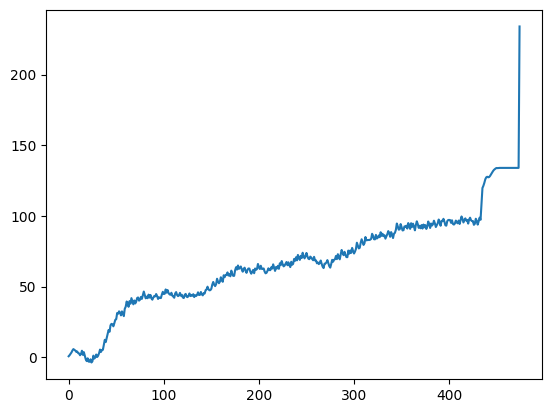

In [43]:
plt.plot(history)

In [21]:
import imageio 
policy = torch.load("policy_complete.pth")
policy.eval()
env = gym.make("LunarLander-v3", render_mode="rgb_array")
# env = RecordVideo(env, video_folder="./videos", name_prefix="lunar_lander_test_3")

rews=[]
frames=[]
success_count = 0
filename = "ppo.mp4"
with imageio.get_writer(filename, fps=30) as video:
    for _ in range(5):
      state, _ = env.reset()
      total = 0
      done = False
      frame = 0
      history = []
      reward=0
      frame_counter=0
      while not done:
        
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        frame += 1
        action_probs = policy.actor(state_tensor)
        action = torch.argmax(action_probs, dim=1).item()  # Select the action with the highest probability
        state, rew, done, _, _ = env.step(action)
        # print(action[0])
        # state, rew, done, _, _ = env.step(action.item())
        # obs = np.expand_dims(np.asarray(obs), axis=0)
        reward+=rew
        video.append_data(env.render())
        frame_counter+=1
      print('Episode reward:', reward, 'Number of frames:', frame_counter)
env.close()

print("Video saved to './videos'")

C:\Users\HP\AppData\Local\Temp\ipykernel_20412\2882276144.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy = torch.load("policy_complete.pth")
IMAGEIO FFMPEG_WRITE

Episode reward: 201.30444738383352 Number of frames: 467
Episode reward: 238.872923703065 Number of frames: 489
Episode reward: 218.061052501641 Number of frames: 479
Episode reward: 221.49202002352922 Number of frames: 497
Episode reward: 227.00680182577793 Number of frames: 492
Video saved to './videos'
